# One Shot Learning For File Type Identification
## Student ID1: 313260382
## Student ID2: 316305531

In [2]:
import random
import numpy as np
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
#load data:
def load(scenario=1, block_size='4k', subset='train'):
  if block_size not in ['512']:
    raise ValueError('Invalid block size!')
  if scenario not in range(1 ,6):
    raise ValueError('Invalid scenario!')
  if subset not in ['train', 'val', 'test']:
    raise ValueError('Invalid subset!')

  data_dir = os.path.join('.', '{:s}_{:1d}'.format(block_size, scenario))
  data = np.load(os.path.join(data_dir, '{}.npz'.format(subset)))
 
  if os.path.isfile('classes.json'):
    with open('classes.json') as json_file:
      classes = json.load(json_file)
      labels = classes[str(scenario)]
  else:
    raise FileNotFoundError('Please download classes.json to the current directory!')

  return data['x'], data['y'], labels

x, y, l = load(1, '512', 'test')
xv, yv, lv = load(1, '512', 'val')

print("Loaded data: x.shape={}, y.shape={}".format(x.shape, y.shape))

Loaded data: x.shape=(768000, 512), y.shape=(768000,)


# List of Filetypes
The classifier has been tested on the following 75 filetypes:<br>
11 types & 75 subtypes
### RAW
ARW, 
CR2, 
DNG, 
GPR, 
NEF, 
NRW, 
ORF, 
PEF, 
RAF, 
RW2, 
3FR
### Bitmap
JPG, 
TIFF,
HEIC,
BMP, 
GIF, 
PNG
### Vector
AI,
EPS,
PSD,
### Video
MOV,
MP4,
3GP,
AVI,
MKV,
OGV,
WEBM,
### Archive
APK,
JAR,
MSI,
DMG,
7Z,
BZ2,
DEB,
GZ,
PKG,
RAR,
RPM,
XZ,
ZIP
### Executables
EXE,
MACH-O,
ELF,
DLL
### Office
DOC,
DOCX,
KEY,
PPT,
PPTX,
XLS,
XLSX
### Published
DJVU,
EPUB,
MOBI,
PDF
### Human-readable
MD,
RTF,
TXT,
TEX,
JSON,
HTML,
XML,
LOG,
CSV,
### Audio
AIFF,
FLAC,
M4A,
MP3,
OGG,
WAV,
WMA
### Other
PCAP,
TTF,
DWG,
SQLITE

In [4]:
# one of each types:
def oneshot(x,y):
    ls=[i for i in range(75)]
    ls_x= []
    ls_y= []
    for index_x , index_y in zip(x,y):
        if index_y in ls:
            if index_y == 0:
                ls_x.append(index_x)
                ls_y.append(1)
                ls.remove(index_y)
            else:
                ls_x.append(index_x)
                ls_y.append(0)
                ls.remove(index_y)
    return np.asarray(ls_x), np.asarray(ls_y)

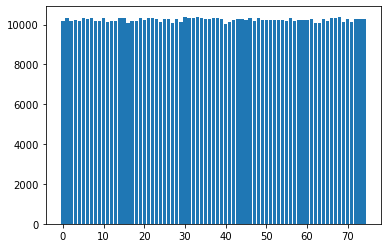

In [9]:
# unique, counts = np.unique(y, return_counts=True)
# D=dict(zip(unique, counts))
# plt.bar(*zip(*D.items()))
# plt.show()

In [4]:
# normalize the data 
(x_train, y_train) = oneshot(x, y)
(x_test, y_test) = xv[:285], yv[:285]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
# make pairs:
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [8]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = Input((1,512))
n = Flatten()(input)
n = Dense(128, activation='relu')(n)
dense = Model(input, n)

input1 = Input((1,512))
input2 = Input((1,512))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [9]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 512)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1, 512)]     0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          65664       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

In [12]:
wandb.init(project="siamese")
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=75, epochs=150, callbacks=[WandbCallback()])

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
GFLOPs,0.00013
accuracy,0.7
epoch,199
loss,0.54108


Epoch 1/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5428 - accuracy: 0.7000
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5420 - accuracy: 0.7000
Epoch 3/200
2/2 [==============================] - 0s 0s/step - loss: 0.5428 - accuracy: 0.7000
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5422 - accuracy: 0.7000
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5419 - accuracy: 0.7000
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5410 - accuracy: 0.7000
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5409 - accuracy: 0.7000
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5415 - accuracy: 0.7000
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5405 - accuracy: 0.7000
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5395 - accuracy: 0.7000
Epoch 11/200
2/2 [============